# Make a reasonable dictionary for JumpType 

In [1]:
import pandas as pd

In [16]:
import numpy as np

In [48]:
dict_wn = 'frequency-alpha-wn.txt'
dict_240k = 'frequency-alpha-alldicts.txt'
dict_330k = 'count_1w.txt'
dict_370k = 'words_alpha.txt'

In [3]:
!head $dict_240k

#RANKING   WORD                             COUNT      PERCENT   CUMULATIVE
1          the                    109,892,823,605    7.591474%    7.591474%
2          of                      66,814,250,204    4.615576%   12.207049%
3          and                     47,936,995,099    3.311521%   15.518571%
4          to                      40,339,918,761    2.786710%   18.305281%
5          in                      34,866,788,790    2.408622%   20.713903%
6          a                       30,285,269,908    2.092128%   22.806031%
7          is                      16,826,445,779    1.162383%   23.968414%
8          that                    16,276,869,660    1.124418%   25.092832%
9          for                     15,302,395,205    1.057100%   26.149932%


In [49]:
df_wn = pd.read_csv(dict_wn, header=0, delim_whitespace=True, index_col = 0, usecols=[0,1,2], thousands=',', dtype={0:'int',1:'str',2:np.int64})

In [18]:
df_240k = pd.read_csv(dict_240k, header=0, delim_whitespace=True, index_col = 0, usecols=[0,1,2], thousands=',', dtype={0:'int',1:'str',2:np.int64})

In [21]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='#RANKING'>

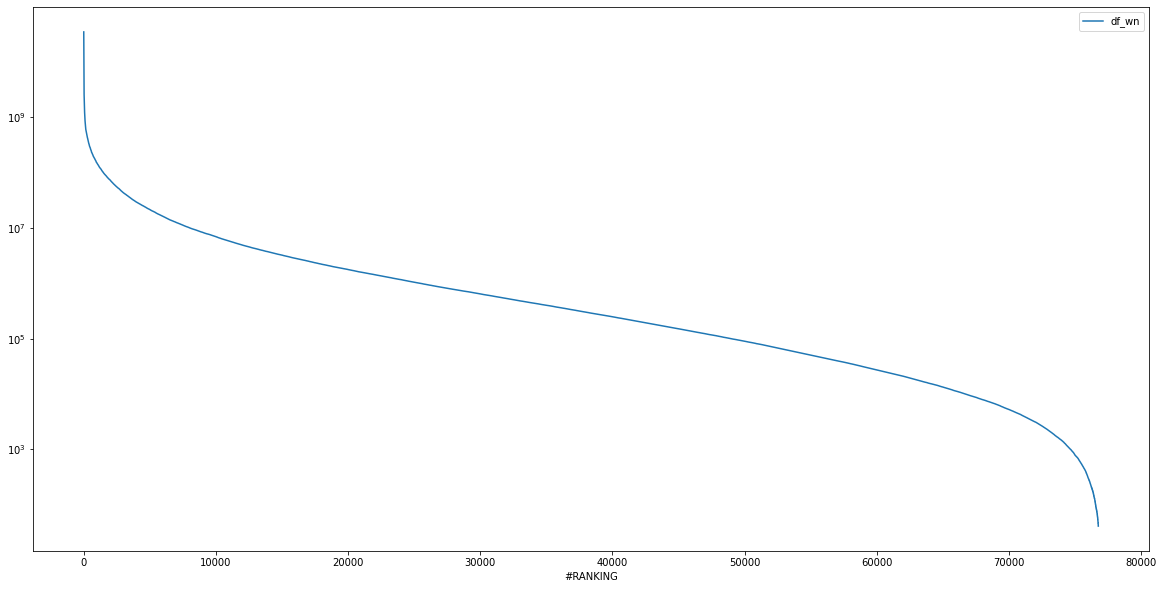

In [79]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
ax.set_yscale('log')
# df_240k.plot(y='COUNT', use_index=True, ax=ax, label='df_240k')
df_wn.plot(y='COUNT', use_index=True, ax=ax, label='df_wn')

<AxesSubplot:xlabel='#RANKING'>

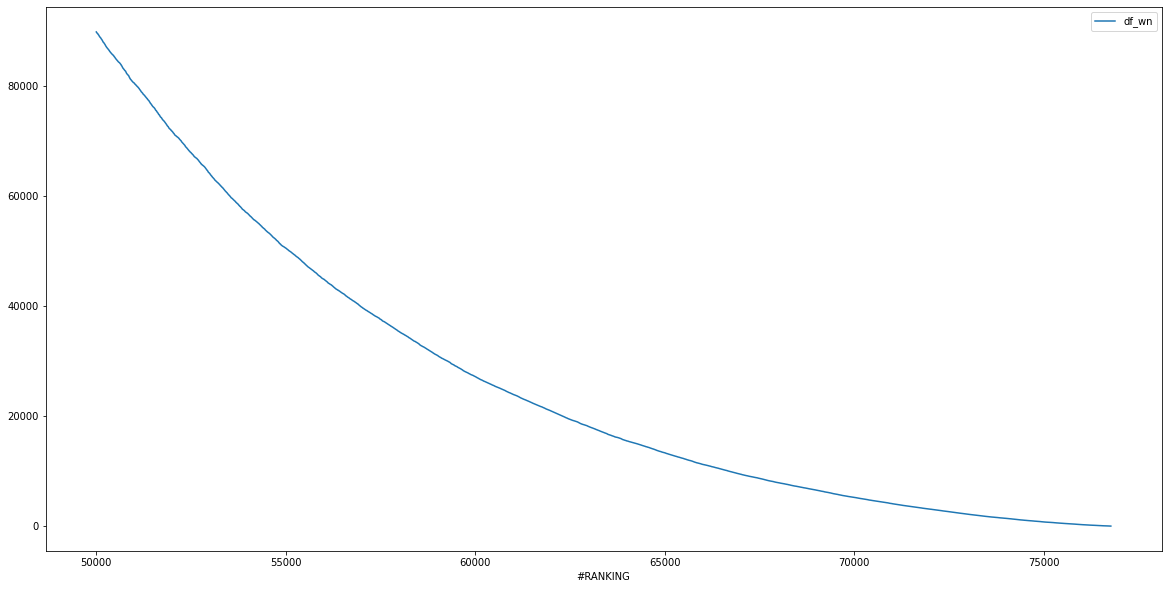

In [86]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
# ax.set_yscale('log')
df_wn[50000:].plot(y='COUNT', use_index=True, ax=ax, label='df_wn')

In [60]:
df_wn.shape

(76769, 2)

In [53]:
df_wn['COUNT'].quantile(0.7)

1286770.3999999997

In [63]:
df_240k['COUNT'].iloc[0:np.int(0.3*246590)].value_counts()

93821      4
105767     4
102534     4
97794      4
96988      3
          ..
1745434    1
1745305    1
1745252    1
1745083    1
92217      1
Name: COUNT, Length: 72207, dtype: int64

In [47]:
df_240k.iloc[np.int(0.3*246590)]

WORD     birdhouse
COUNT        92215
Name: 73978, dtype: object

In [44]:
df_240k['COUNT'].quantile(0.7)

92215.59999999998

In [65]:
df_240k.iloc[100000]

WORD     neopallium
COUNT         29973
Name: 100001, dtype: object

In [67]:
df_wn['COUNT'].quantile(0.2)

22701.800000000003

In [89]:
df_wn.iloc[30000]

WORD     unafraid
COUNT      642898
Name: 30001, dtype: object

In [91]:
df_wn[df_wn['COUNT'] == 30000]

,WORD,COUNT
#RANKING,,
59274,Modicon,30000


In [93]:
df_wn_special = df_wn[df_wn['WORD'].str.islower()]

ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [94]:
df_wn['WORD'].str

## clean up wiktionary 

In [5]:
dict_name = 'enwiktionary-latest-all-titles'
dict_cleaned = dict_name+'_cleaned'

In [12]:
with open(dict_cleaned, 'w', encoding='utf-8') as out:
	with open(dict_name, 'r', encoding='utf-8') as f:
		for l in f:
			l = l.strip()
			ls = l.split('\t')
			if len(ls) == 2:
				word = ls[1]
				if word.isalpha() and word.isascii() and len(word) > 4:
					out.write(word+'\n')